## Whatsapp Analyzer
### Process
- Read & Cleaning Data
- Preprocessing Data
- Make Model


In [ ]:
!pip install emoji==1.7.0
!pip install PySastrawi 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download Data
!gdown  --id '14yjdD76QjkvpZw1KgBWd-REPRfM_nz6R' -O purba_wa.txt

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=14yjdD76QjkvpZw1KgBWd-REPRfM_nz6R
To: /content/purba_wa.txt
100% 570k/570k [00:00<00:00, 83.8MB/s]


In [ ]:
# Import Library
import emoji
import numpy as np
import pandas as pd
import re
import regex  
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Try Read data
# data_frame = pd.read_csv('/content/purba_wa.txt')

In [ ]:
# ekstrak data tanggal
def date_time(s):
  pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -'
  result = re.match(pattern, s)
  if result:
    return True
  return False

# extract username in the chats group
def find_author(s):
  s = s.split(":")
  if len(s)==2:
    return True
  else:
    return False

# Separate all information
def GetDataPoint(line):
  splitLine = line.split(' - ')
  dateTime = splitLine[0]
  date, time = dateTime.split(', ')
  message = ' '.join(splitLine[1:])
  if find_author(message):
    splitMessage = message.split(': ')
    author = splitMessage[0]
    message = ' '.join(splitMessage[1:])
  else:
    author = None
  return date, time, author, message

# extract emoji 
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)

    return emoji_list

In [ ]:
parseData= []
data = []
text_data = '/content/purba_wa.txt'
with open(text_data, encoding = "utf-8") as fp:
  fp.readline()
  messageBuffer = []
  date, time, partisipan = None, None, None
  while True:
    line = fp.readline()
    if not line:
      break
    line = line.strip()
    if date_time(line):
      if len(messageBuffer) > 0:
        parseData.append([date, time, partisipan, ' '.join(messageBuffer)]) 
      messageBuffer.clear()
      date, time, partisipan, message = GetDataPoint(line)
      messageBuffer.append(message)
    else:
      messageBuffer.append(line)

In [ ]:
clean_data = pd.DataFrame(parseData, columns=['Tanggal',
                                              'Waktu',
                                              'Nama User',
                                              'Pesan'])#make dataframe

clean_data['Tanggal'] = pd.to_datetime(clean_data['Tanggal'])#Buat format tanggal

clean_data['Emoji'] = clean_data['Pesan'].apply(split_count)#ekstrak emoji dari pesan

# kolom panjang pesan
panjang = [len(clean_data['Pesan'][i]) for i in range(len(clean_data))]
clean_data['Panjang Pesan'] = panjang
clean_data.head(10)

,Tanggal,Waktu,Nama User,Pesan,Emoji,Panjang Pesan
0,2018-10-14,8:54 PM,Bang Andre,Ok,[],2
1,2018-10-14,8:54 PM,Bang Andre,Mandi dulu,[],10
2,2018-10-14,8:54 PM,Kaka Dina,Sip sip,[],7
3,2018-10-14,8:54 PM,ario,Mntap,[],5
4,2018-10-14,8:54 PM,ario,Siapa adminya,[],13
5,2018-10-14,8:55 PM,Kaka Dina,Hahahhahha,[],10
6,2018-10-14,8:58 PM,None,Kaka Dina changed this group's icon,[],35
7,2018-10-14,8:59 PM,Bang Andre,"Ada"" aja ya, udah main grup aja. Bapak suruh b...",[😁],69
8,2018-10-14,8:59 PM,None,Kaka Dina changed this group's icon,[],35
9,2018-10-14,9:00 PM,Kaka Dina,"Hahahhahha,,, rencana ya gtu",[],28


In [ ]:
clean_data['Nama User'].unique()

array(['Bang Andre', 'Kaka Dina', 'ario', None, 'Adek Abet', 'Mamak Cu',
       'Bapak Wa', 'Rachel', 'Bang Andre P'], dtype=object)

In [ ]:
# Bersihkan Data Pesan
clean_data = clean_data[clean_data.Pesan != '<Media omitted>']
clean_data = clean_data[clean_data.Pesan != 'This message was deleted']

In [ ]:
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stop_factory = StopWordRemoverFactory()
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import re

factory = StopWordRemoverFactory()
stopwords = factory.create_stop_word_remover()

messages = []

for words in clean_data['Pesan']:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = only_letters.split()  # tokenize the sentences
    lower_case = [l.lower() for l in tokens]  # convert all letters to lower case
    filtered_result = [word for word in lower_case if not stopwords.remove(word)] # Remove stopwords from the comments
    lemmas = [stemmer.stem(t) for t in filtered_result]  # lemmatizes the words to their base form

    messages.append(' '.join(lemmas))


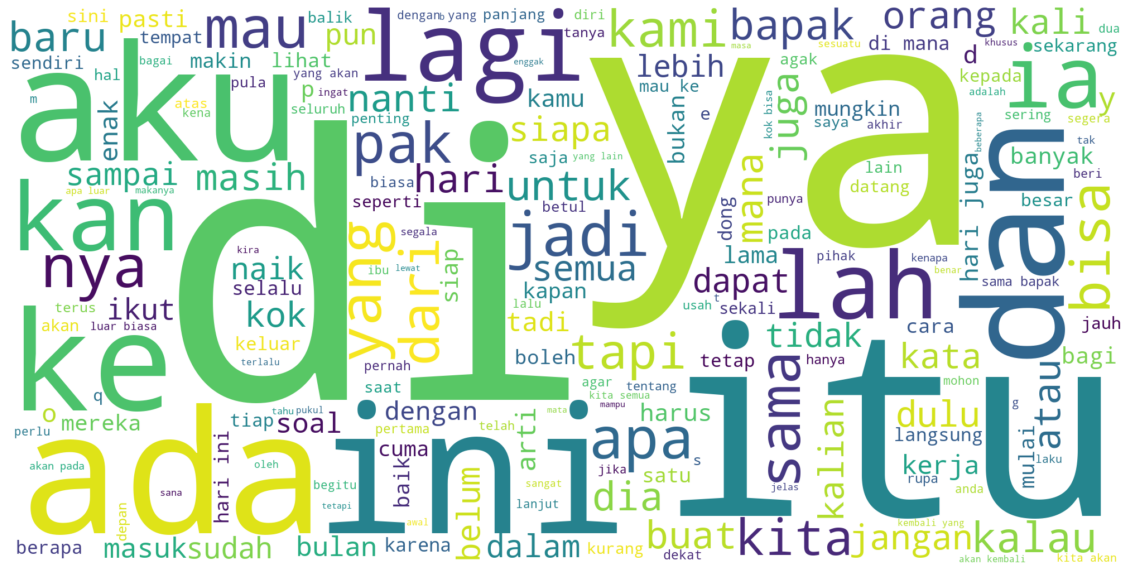

In [ ]:
#Let's use worldcloud to visualize the messages
unique_string=(" ").join(messages)
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# Cek Emoji Paling Sering Digunakan
total_emojis_list = list([a for b in clean_data.Emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
for i in emoji_dict:
  print(i)

('😂', 203)
('😊', 119)
('😀', 106)
('👍', 93)
('😁', 86)
('😇', 78)
('🤣', 61)
('🙏', 55)
('🙂', 33)
('😃', 28)
('😭', 26)
('🤗', 26)
('😆', 23)
('💪', 21)
('😅', 19)
('😄', 18)
('👌', 17)
('🥰', 15)
('❤', 12)
('🏠', 11)
('👍🏻', 11)
('📆', 10)
('🙏🏻', 10)
('😛', 10)
('🕗', 9)
('🎉', 9)
('❤️', 8)
('🥳', 7)
('😎', 7)
('😘', 7)
('😉', 6)
('😍', 6)
('💖', 6)
('😝', 5)
('🌟', 5)
('🔹', 5)
('😢', 4)
('💪🏻', 4)
('☺️', 4)
('✨', 4)
('😚', 4)
('🎂', 4)
('📑', 4)
('📍', 4)
('💕', 3)
('💓', 3)
('😪', 3)
('✋', 2)
('😲', 2)
('💵', 2)
('☺', 2)
('😜', 2)
('🤔', 2)
('🏅', 2)
('👋', 2)
('😌', 2)
('🤦\u200d♂️', 2)
('🕐', 2)
('‼️', 2)
('😮\u200d💨', 2)
('🤓', 2)
('🖐️', 1)
('🤚', 1)
('🕑', 1)
('✊', 1)
('😣', 1)
('🖐', 1)
('👏', 1)
('👼', 1)
('👇', 1)
('🤪', 1)
('🎊', 1)
('🎓', 1)
('📲', 1)
('🌞', 1)
('👆', 1)
('🤦', 1)
('🤝', 1)
('😓', 1)
('🌄', 1)
('🙋', 1)
('💝', 1)
('📚', 1)
('🌼', 1)
('🙏🏾', 1)
('\U0001f972', 1)
('😖', 1)
('\U0001fae1', 1)


/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128591 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128578 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129315 missing from current font.
  font.

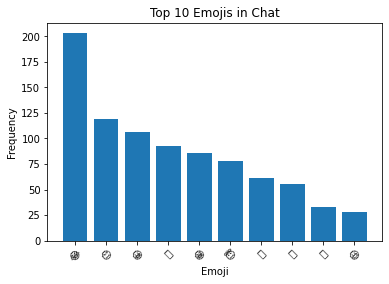

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Create a flattened list of all the emojis
total_emojis_list = list([a for b in clean_data.Emoji for a in b])

# Count the frequency of each unique emoji
emoji_dict = dict(Counter(total_emojis_list))

# Sort the dictionary by frequency in descending order
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 most frequent emojis
top_emojis = emoji_dict[:10]

# Create lists of the top 10 emojis and their frequencies
emojis = [e[0] for e in top_emojis]
frequencies = [e[1] for e in top_emojis]

# Create a bar chart of the top 10 emojis
plt.bar(emojis, frequencies)

# Set the title and axis labels
plt.title('Top 10 Emojis in Chat')
plt.xlabel('Emoji')
plt.ylabel('Frequency')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


In [ ]:
# Cek Pengirim pesan terbanyak
total_chat = clean_data['Nama User'].tolist()
user_dict = dict(Counter(total_chat))
user_dict = sorted(user_dict.items(), key=lambda x: x[1], reverse=True)
for i in user_dict:
  print(i)

('Kaka Dina', 3868)
('ario', 1239)
('Bang Andre', 1209)
('Adek Abet', 703)
('Mamak Cu', 467)
('Bang Andre P', 462)
(None, 193)
('Bapak Wa', 153)
('Rachel', 29)
